In [1]:
# %matplotlib widget
%matplotlib inline
import sympy as sp
import sympy.physics.mechanics as me
import sympy.plotting as splt
from typing import Dict, List, Tuple
from sympy import sin, cos, pi, sqrt, acos, simplify, atan
import math
import matplotlib.pyplot as plt
import numpy as np
me.init_vprinting()

g, t = sp.symbols('g, t')
origin = sp.Matrix([0, 0, 0, 1])
def homogeneous(rotation: sp.Matrix = sp.eye(3), translation: sp.Matrix = sp.zeros(3, 1)) -> sp.Matrix:
    return rotation.row_join(translation).col_join(sp.Matrix([[0, 0, 0, 1]]))

def dh(rotation, twist, displacement, offset):
    rotation_mat = sp.Matrix([
        [cos(rotation), -sin(rotation)*cos(twist),  sin(rotation)*sin(twist)],
        [sin(rotation), cos(rotation)*cos(twist),   -cos(rotation)*sin(twist)],
        [0,             sin(twist),                 cos(twist)],
    ])
    translation = sp.Matrix([
        [offset*cos(rotation)],
        [offset*sin(rotation)],
        [displacement],
    ])
    return rotation_mat, translation

def rotation(homogeneous: sp.Matrix):
    return homogeneous[:3, :3]

def translation(homogeneous: sp.Matrix):
    return homogeneous[:3, 3:]

def chained_transform(transforms: List[sp.Matrix]):
    transforms_chained = [homogeneous()]
    for transform in transforms:
        transforms_chained.append(transforms_chained[-1] * transform)
    return transforms_chained

def z_vecs(transforms: List[sp.Matrix]):
    transforms_chained = chained_transform(transforms)
    z_unit_vecs = []
    for transform in transforms_chained:
        z_unit_vecs.append(rotation(transform) * sp.Matrix([0, 0, 1]))
    return z_unit_vecs

def jacobian(transforms: List[sp.Matrix], joint_types: List[sp.Matrix], base_z: sp.Matrix = sp.Matrix([0, 0, 1])):
    transforms_chained = chained_transform(transforms)
    z_unit_vecs = z_vecs(transforms)
    
    assert len(transforms_chained) == len(z_unit_vecs)

    jacobian = sp.zeros(6, len(transforms))
    for i, (transform, joint_type) in enumerate(zip(transforms, joint_types)):
        if joint_type == 'revolute':
            jacobian[:3, i] = z_unit_vecs[i].cross(translation(transforms_chained[-1]) - translation(transforms_chained[i]))
            jacobian[3:, i] = z_unit_vecs[i]
        elif joint_type == 'prismatic':
            jacobian[:3, i] = z_unit_vecs[i]
            jacobian[3:, i] = sp.Matrix([[0], [0], [0]])

        # angular velocity

    return jacobian

def skew(v: sp.Matrix):
    return sp.Matrix([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0],
    ])

def compute_dynamics(H: List[sp.Matrix],
                     q: List[sp.Matrix], 
                     q_dot: List[sp.Matrix], 
                     q_dot_dot: List[sp.Matrix],
                     joint_types: List[str], 
                     m: List[float], I: List[float], 
                     r_c: List[sp.Matrix], 
                     g_vec: sp.Matrix):
    # J = jacobian(all_joints, joint_types)

    w = [sp.Matrix([0, 0, 0])]*(len(H)+1) # joint linear velocities
    v = [sp.Matrix([0, 0, 0])]*(len(H)+1) # joint angular velocities
    v_c = [sp.Matrix([0, 0, 0])]*(len(H)+1) # joint CoM linear velocities
    # T = sp.zeros(len(H)+1, 1) # joint kinetic energy
    # V = sp.zeros(len(H)+1, 1) # joint potential energy
    T = [sp.Matrix([0])]*(len(H)+1) # joint kinetic energy
    V = [sp.Matrix([0])]*(len(H)+1) # joint potential energy

    chained_transforms = chained_transform(H)
    # chained_translations = chained_translation(all_joints)
    # z = z_vecs(all_joints) # joint origins
    z = sp.Matrix([0, 0, 1]) # computing dynamics asks for z in its own frame, which is this

    for i, joint, joint_type in zip(range(1, len(H) + 1), H, joint_types):
        # Compute angular velocity
        theta_dot = q_dot[i-1] if joint_type == 'revolute' else 0
        w[i] = rotation(joint).T * (w[i-1] + z*theta_dot)

        # Compute linear velocity
        d_dot = q_dot[i-1] if joint_type == 'prismatic' else 0
        r_i = (joint*origin)[:3, :]
        v[i] = rotation(joint).T * (v[i-1] + z*d_dot) + w[i].cross(r_i)

        # Compute CoM linear velocity
        v_c[i] = v[i] + w[i].cross(r_c[i][:3, :])

        # Compute kinetic energy
        T[i] = 0.5*m[i]*v_c[i].T*v_c[i] + 0.5*w[i].T*I[i]*w[i]

        # Compute potential energy
        p_ci = (chained_transforms[i]*r_c[i])[:3, :]
        V[i] = -m[i]*g_vec.T*p_ci


    # Sum kinetic, potential energies
    T_sum = sp.zeros(1)
    V_sum = sp.zeros(1)
    for t_i in T:
        T_sum += t_i
    # T = simplify(T_sum)
    T = T_sum
    for v_i in V:
        V_sum += v_i
    # V = simplify(V_sum)
    V = V_sum

    # Compute Langragian
    L = T - V

    # Compute torques
    torques = []
    for i in range(1, len(H) + 1):
        torque = L.diff(q_dot[i-1]).diff(t)-L.diff(q[i-1])
        # torque = torque[0]
        torque = simplify(torque[0])
        display(torque)
        torques.append(torque)

    # accel_sol = sp.solve(torques, q_dot_dot)
    # # display(accel_sol)
    # vel_sol = sp.solve(torques, q_dot)
    # # display(vel_sol)
    # g_sol = sp.solve(torques, g)
    # M = sp.Matrix(accel_sol.values())
    # C = sp.Matrix(vel_sol.values())
    # G = sp.Matrix(g_sol.values())
    # display(M)
    # M = sp.zeros(len(H), len(q))
    # # C = sp.zeros(len(H), len(q))
    # # G = sp.zeros(len(H), 1)
    # for i, torque in enumerate(torques):
    #     for j, qdd in enumerate(q_dot_dot):
    #         torque_poly = sp.Poly(torque, qdd)
    #         display(torque_poly.all_coeffs())
    #         display(len(torque_poly.all_coeffs()))
    #         M[i, j] = torque_poly.all_coeffs()
        # display(torques[i-1].collect(q_dot_dot[i-1]))
        # display(torques[i-1].collect(q_dot[i-1]))
        # display(sp.factor_list(torques[i-1], q_dot_dot[0]))
        # display(sp.factor_list(torques[i-1], q_dot[0]))
    # display(M)
    #     ...

    return L, torques

def poly(symbol: str, degree: int):
    N = degree + 1
    coeffs = [sp.symbols(f'{symbol}_{i}') for i in range(N)]
    return coeffs, sum([c*t**i for i, c in enumerate(coeffs)])

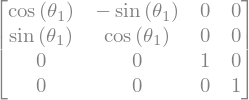

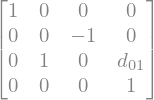

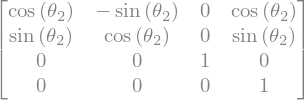

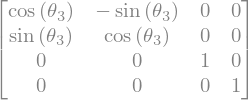

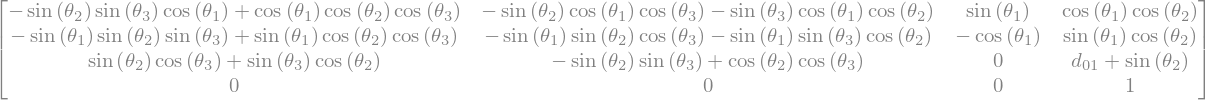

'\\left[\\begin{matrix}- \\sin{\\left(\\theta_{2}{\\left(t \\right)} \\right)} \\sin{\\left(\\theta_{3}{\\left(t \\right)} \\right)} \\cos{\\left(\\theta_{1}{\\left(t \\right)} \\right)} + \\cos{\\left(\\theta_{1}{\\left(t \\right)} \\right)} \\cos{\\left(\\theta_{2}{\\left(t \\right)} \\right)} \\cos{\\left(\\theta_{3}{\\left(t \\right)} \\right)} & - \\sin{\\left(\\theta_{2}{\\left(t \\right)} \\right)} \\cos{\\left(\\theta_{1}{\\left(t \\right)} \\right)} \\cos{\\left(\\theta_{3}{\\left(t \\right)} \\right)} - \\sin{\\left(\\theta_{3}{\\left(t \\right)} \\right)} \\cos{\\left(\\theta_{1}{\\left(t \\right)} \\right)} \\cos{\\left(\\theta_{2}{\\left(t \\right)} \\right)} & \\sin{\\left(\\theta_{1}{\\left(t \\right)} \\right)} & \\cos{\\left(\\theta_{1}{\\left(t \\right)} \\right)} \\cos{\\left(\\theta_{2}{\\left(t \\right)} \\right)}\\\\- \\sin{\\left(\\theta_{1}{\\left(t \\right)} \\right)} \\sin{\\left(\\theta_{2}{\\left(t \\right)} \\right)} \\sin{\\left(\\theta_{3}{\\left(t \\righ

In [2]:
"""
Design the robot
"""

# Design Parameters
# l_arm = sp.symbols('l_{arm}')
l_arm = 1

# Joint Variables
joint_variable_names = ['theta_1', 'd_01', 'theta_2', 'theta_3'] 
turret_angle, elev_pos, shoulder_angle, wrist_angle = me.dynamicsymbols(joint_variable_names)
turret_vel, elev_vel, shoulder_vel, wrist_vel =  me.dynamicsymbols(joint_variable_names, level=1)
turret_accel, elev_accel, shoulder_accel, wrist_accel =  me.dynamicsymbols(joint_variable_names, level=2)

q = sp.Matrix([turret_angle, elev_pos, shoulder_angle, wrist_angle])
q_dot = sp.Matrix([turret_vel, elev_vel, shoulder_vel, wrist_vel])
q_dot_dot = sp.Matrix([turret_accel, elev_accel, shoulder_accel, wrist_accel])

# I_c = sp.symbols('I_c1^1 I_c2^2 I_c3^3 I_c4^4')
I_c = [sp.eye(3)]*4
# m = sp.symbols('m_1 m_2 m_3 m_4')
m = [1, 1, 1, 1]
r_c = [sp.Matrix([0, 0, 0, 1]), sp.Matrix([0, 0, 0, 1]), sp.Matrix([0, 0, 0, 1]), sp.Matrix([0, 0, 0, 1])]
g_in0 = sp.Matrix([0, 0, -g])

# Joint Transforms
turret = homogeneous(*dh(turret_angle, 0, 0, 0))
elevator = homogeneous(*dh(0, pi/2, elev_pos, 0))
shoulder = homogeneous(*dh(shoulder_angle, 0, 0, l_arm))
wrist = homogeneous(*dh(wrist_angle, 0, 0, 0))

base_to_end = turret * elevator * shoulder * wrist

display(turret)
display(elevator)
display(shoulder)
display(wrist)
display(base_to_end)
sp.latex(base_to_end)

'Forward kinematics = end effector position in base frame'

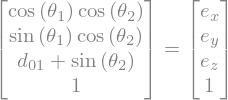

'Solutions:'

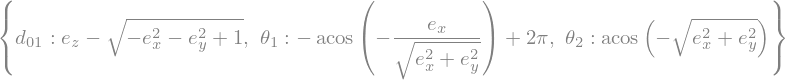

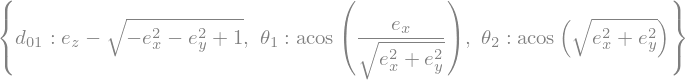

In [3]:
"""
Solve inverse kinematics
"""

# Define symbols for position of end effector in the base frame
e_x, e_y, e_z = sp.symbols('e_x e_y e_z')
end_pos = sp.Matrix([e_x, e_y, e_z, 1])

# Define equality between forward kinematics and end effector position
eq = sp.Eq(base_to_end*sp.Matrix([0, 0, 0, 1]), end_pos)
display("Forward kinematics = end effector position in base frame", eq)

# Solve for joint variables
sols = sp.solve(eq, turret_angle, elev_pos, shoulder_angle, wrist_angle)

display("Solutions:")
for sol in sols:
    display(sol)

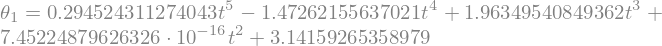

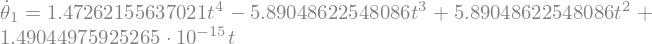

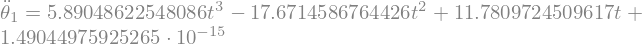

In [18]:
"""
Generate a pick and place trajectory.
"""

# Define the 3D trajectory
path_3d = [
    [1, 0, 0], # Pick
    # [0.5, 0.5, 0], # Stow
    [0, 1, 1], # Place
]
times = [0, 2]

# Create list of joint states for each point in the trajectory
path_joints = {j: [] for j in sols[0].keys()}
for j, sol in sols[0].items():
    for (x, y, z) in path_3d:
        path_joints[j].append(sol.evalf(subs={e_x: x, e_y: y, e_z: z}))
display(path_joints)
joint_exprs = {}

for i, joint in enumerate(path_joints.keys()):
    # if joint not in inverse kinematics solution, skip
    if joint not in sols[0]:
        continue

    # Create polynomial trajectory
    traj_coeffs, traj_expr = poly(chr(ord('a') + i), 5)
    
    # Create list of constraints
    constraints = []
    for time, pos in zip(times, path_joints[joint]):
        constraints.append(sp.Eq(traj_expr.subs(t, time), pos))

    constraints.append(sp.Eq(traj_expr.diff(t).subs(t, times[0]), 0))
    constraints.append(sp.Eq(traj_expr.diff(t).subs(t, times[-1]), 0))
    constraints.append(sp.Eq(traj_expr.diff(t).diff(t).subs(t, times[0]), 0))
    constraints.append(sp.Eq(traj_expr.diff(t).diff(t).subs(t, times[-1]), 0))

    # Solve for trajectory coefficients
    traj_sols = sp.solvers.polysys.solve_poly_system(
        constraints,
        traj_coeffs
    )
    joint_exprs[joint] = traj_expr.subs({c: s for c, s in zip(traj_coeffs, traj_sols[0])}).evalf()
    display(sp.Eq(joint, joint_exprs[joint])) 
    display(sp.Eq(joint.diff(t), joint_exprs[joint].diff(t))) 
    display(sp.Eq(joint.diff(t).diff(t), joint_exprs[joint].diff(t).diff(t))) 

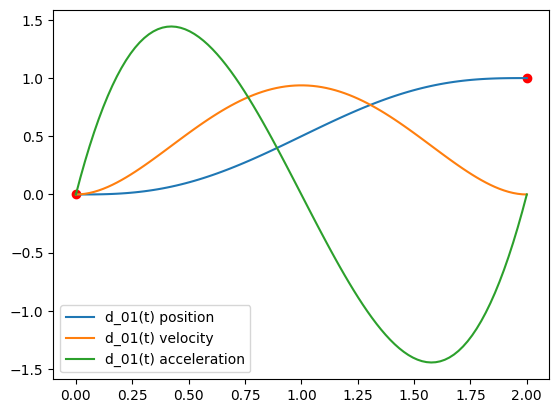

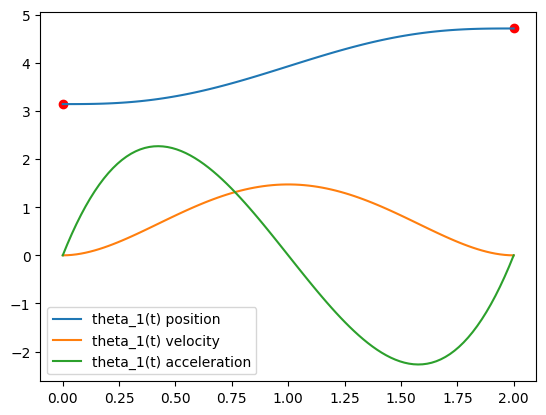

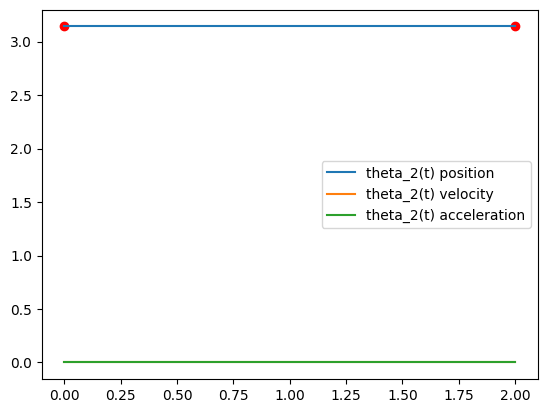

In [5]:
# For each joint expr, plot desired points and trajectory
for joint, expr in joint_exprs.items():
    n = 100
    ts = np.linspace(times[0], times[-1], n)
    pos_fn = sp.lambdify(t, expr)(ts)
    vel_fn = sp.lambdify(t, expr.diff(t))(ts)
    acc_fn = sp.lambdify(t, expr.diff(t).diff(t))(ts)
    # get around vectorization issue with shoulder angle
    if joint is shoulder_angle:
        pos_fn = np.full_like(ts, pos_fn)
        vel_fn = np.full_like(ts, vel_fn)
        acc_fn = np.full_like(ts, acc_fn)
    plt.plot(times, path_joints[joint], 'ro')
    plt.plot(ts, pos_fn, label=f"{joint} position")
    plt.plot(ts, vel_fn, label=f"{joint} velocity")
    plt.plot(ts, acc_fn, label=f"{joint} acceleration")
    plt.legend()
    plt.show()

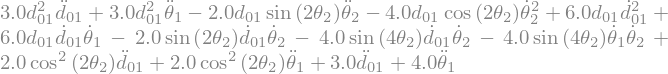

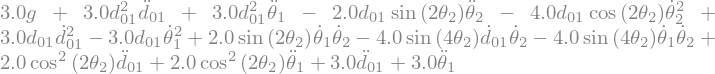

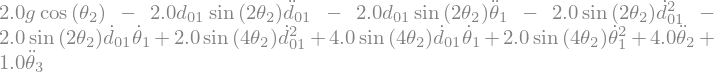

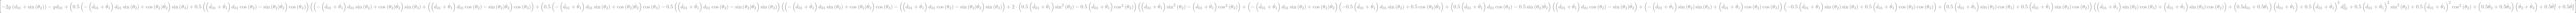

'Torque 0'

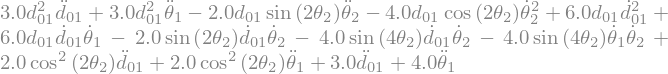

'Torque 1'

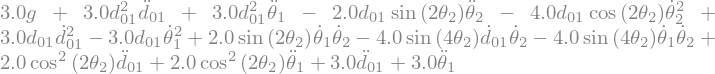

'Torque 2'

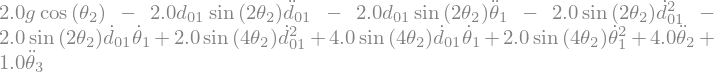

'Torque 3'

In [6]:
L, torques = compute_dynamics(
    [turret, elevator, shoulder, wrist],
    q,
    q_dot,
    q_dot_dot,
    ['revolute', 'revolute', 'revolute', 'revolute'],
    [0] + list(m),
    [0] + list(I_c),
    [0] + list(r_c),
    g_in0
)

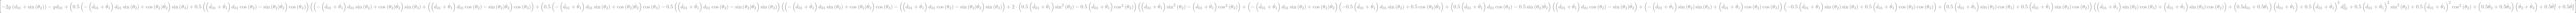

\left[\begin{matrix}- 2 g \left(d_{01}{\left(t \right)} + \sin{\left(\theta_{2}{\left(t \right)} \right)}\right) - g d_{01}{\left(t \right)} + \left(0.5 \left(- \left(\frac{d}{d t} d_{01}{\left(t \right)} + \frac{d}{d t} \theta_{1}{\left(t \right)}\right) d_{01}{\left(t \right)} \sin{\left(\theta_{2}{\left(t \right)} \right)} + \cos{\left(\theta_{2}{\left(t \right)} \right)} \frac{d}{d t} \theta_{2}{\left(t \right)}\right) \sin{\left(\theta_{3}{\left(t \right)} \right)} + 0.5 \left(\left(\frac{d}{d t} d_{01}{\left(t \right)} + \frac{d}{d t} \theta_{1}{\left(t \right)}\right) d_{01}{\left(t \right)} \cos{\left(\theta_{2}{\left(t \right)} \right)} - \sin{\left(\theta_{2}{\left(t \right)} \right)} \frac{d}{d t} \theta_{2}{\left(t \right)}\right) \cos{\left(\theta_{3}{\left(t \right)} \right)}\right) \left(\left(- \left(\frac{d}{d t} d_{01}{\left(t \right)} + \frac{d}{d t} \theta_{1}{\left(t \right)}\right) d_{01}{\left(t \right)} \sin{\left(\theta_{2}{\left(t \right)} \right)} + \cos{\lef

'Torque 0'

'Torque 1'

'Torque 2'

'Torque 3'

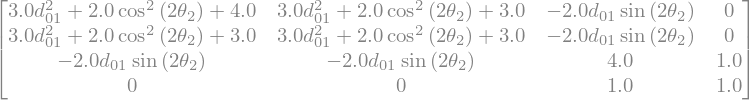

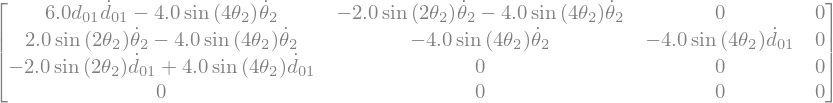

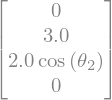

In [28]:
display(L)
print(sp.latex(L))
M = sp.zeros(4, 4)
C = sp.zeros(4, 4)
G = sp.zeros(4, 1)
for i, torque in enumerate(torques):
    display(f"Torque {i}")
    collected_qdd = torque.collect(q_dot_dot)
    collected_qd = torque.collect(q_dot)
    for j, qdd in enumerate(q_dot_dot):
        M[i, j] = collected_qdd.coeff(qdd)
    for j, qd in enumerate(q_dot):
        C[i, j] = collected_qd.coeff(qd)
    G[i] = torque.collect(g_in0).coeff(g)
display(M)
display(C)
display(G)
